# Evaluating ML Models as Agent Tools

In this notebook, we'll demonstrate how to evaluate traditional ML models when used as tools within LangGraph agents. We'll build a clinical trial feedback analysis agent and show multiple evaluation approaches:

1. **End-to-End Evaluation** - Does the agent produce correct final responses?
2. **Single Step Evaluation** - Did the agent correctly select the right tool?
3. **Trajectory Evaluation** - Did the agent take the expected path of tool calls?
4. **ML Model Metrics** - Precision, Recall, F1, Accuracy, Calibration on the model itself

This pattern applies to any ML model or tool called by an agent


## Evaluations: Key Concepts

**Evaluations** are a quantitative way to measure performance of agents, which is important because LLMs don't always behave predictably — small changes in prompts, models, or inputs can significantly impact results. Evaluations provide a structured way to identify failures, compare changes across different versions of your application, and build more reliable AI applications.

Evaluations are made up of three components:

1. A **dataset** with test inputs and expected outputs.
2. An **application or target function** that defines what you are evaluating, taking in inputs and returning the application output
3. **Evaluators** that score your target function's outputs.

![Evaluation](images/evals-conceptual.png)

In this notebook, we'll cover:

1. **End-to-End (Final Response)**: Evaluate the agent's overall output quality
2. **Single Step**: Evaluate whether the agent selects the appropriate tool
3. **Trajectory**: Evaluate whether the agent took the expected path of tool calls
4. **ML Model Metrics**: Evaluate the ML tool directly with precision, recall, F1, accuracy


## Setup


### Install Dependencies

First, let's install the required packages. We need:
- `transformers` and `torch` for the HuggingFace sentiment model
- `langchain` and `langgraph` for building the agent
- `langsmith` and `openevals` for evaluations


### Load Environment Variables

**Use Case: Clinical Trial Participant Feedback Analysis**

In pharmaceutical research, analyzing sentiment from clinical trial participant feedback helps identify:
- Treatment satisfaction and efficacy perceptions
- Side effect severity and patient concerns  
- Early signals of safety issues
- Overall participant experience

We'll build an agent that uses sentiment analysis to classify this feedback, then evaluate it thoroughly.

Make sure you have the following environment variables set:
- `LANGSMITH_API_KEY` - For LangSmith evaluations
- `OPENAI_API_KEY` - For the LLM powering the agent


In [1]:
from dotenv import load_dotenv
load_dotenv(override=True)

from langchain.chat_models import init_chat_model

# Initialize the LLM for our agent
model = init_chat_model("openai:gpt-4o-mini")


## Part 1: Building the Sentiment Analysis Agent


### 1.1 Create the Sentiment Analysis Tool

We'll wrap a HuggingFace sentiment analysis model as a LangChain tool. This model (`distilbert-base-uncased-finetuned-sst-2-english`) classifies text as POSITIVE or NEGATIVE.


In [2]:
from transformers import pipeline
from langchain_core.tools import tool

# Initialize the HuggingFace sentiment pipeline
sentiment_pipeline = pipeline(
    "sentiment-analysis", 
    model="distilbert-base-uncased-finetuned-sst-2-english"
)

@tool
def analyze_sentiment(text: str) -> dict:
    """
    Analyze the sentiment of the given text.
    Returns the sentiment label (POSITIVE/NEGATIVE) and confidence score.
    
    Args:
        text: The text to analyze for sentiment
    
    Returns:
        dict with 'label' (POSITIVE/NEGATIVE) and 'score' (confidence 0-1)
    """
    result = sentiment_pipeline(text)[0]
    return {"label": result["label"], "score": round(result["score"], 4)}

# Test the tool
print("Testing sentiment tool:")
print(analyze_sentiment.invoke("I love this product, it's amazing!"))
print(analyze_sentiment.invoke("This is terrible, I hate it."))


Device set to use mps:0


Testing sentiment tool:
{'label': 'POSITIVE', 'score': 0.9999}
{'label': 'NEGATIVE', 'score': 0.9996}


### 1.2 Create a tool to flag for review

This tool complements the sentiment analysis by adding an **actionable triage layer** - while sentiment tells us *how* a participant feels, the flag tool identifies feedback that needs *immediate human review*, regardless of overall sentiment.

In [3]:
@tool  
def flag_for_review(text: str) -> dict:
    """
    Check if feedback should be flagged for urgent medical team review.
    Use this when feedback mentions serious concerns.
    
    Args:
        text: The feedback text to evaluate
    
    Returns:
        dict with 'requires_review' (bool) and 'reason'
    """
    urgent_keywords = ["withdraw", "discontinue", "severe", "emergency", "hospitalized", "worse"]
    has_urgent_keyword = any(kw in text.lower() for kw in urgent_keywords)
    
    if has_urgent_keyword:
        return {"requires_review": True, "reason": "Contains urgent keywords - recommend medical team review"}
    return {"requires_review": False, "reason": "No urgent flags detected"}

### 1.3 Create the Agent

Now let's create a simple agent using LangChain's `create_agent()` that can use our sentiment analysis tool.


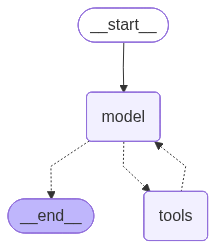

In [4]:
from langchain.agents import create_agent
from langgraph.checkpoint.memory import MemorySaver

# System prompt for our clinical trial feedback sentiment agent
sentiment_agent_prompt = """
You are a clinical trial feedback analyst that helps pharmaceutical researchers 
understand participant sentiment and identify feedback requiring urgent attention.

You have access to two tools:
1. analyze_sentiment - Use this to classify feedback as positive or negative
2. flag_for_review - Use this to check if feedback should be flagged for urgent medical team review

When given participant feedback:
- ALWAYS use analyze_sentiment to determine the sentiment
- ONLY use flag_for_review if the sentiment response from analyze_sentiment is negative to check for urgent concerns that need medical team attention
- After using the tools, provide a comprehensive summary including:
  - The sentiment classification and what it indicates
  - Whether the feedback is flagged for review and why

If the user asks something unrelated to clinical trial feedback analysis, politely 
explain that you specialize in analyzing participant feedback from clinical studies.
"""

# Create checkpointer for conversation memory
checkpointer = MemorySaver()

# Create the agent
sentiment_agent = create_agent(
    model=model,
    tools=[analyze_sentiment, flag_for_review],
    name="clinical_feedback_agent",
    system_prompt=sentiment_agent_prompt,
    checkpointer=checkpointer
)

sentiment_agent


### 1.4 Test the Agent


In [5]:
from langchain_core.messages import HumanMessage
from langsmith import uuid7

# Test with clinical trial participant feedback
config = {"configurable": {"thread_id": uuid7()}}

result = sentiment_agent.invoke(
    {"messages": [HumanMessage(content="Analyze this participant feedback: 'This treatment has been life-changing! My symptoms have completely disappeared and I feel better than I have in years. I'm so grateful I enrolled in this trial.'")]},
    config=config
)

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Analyze this participant feedback: 'This treatment has been life-changing! My symptoms have completely disappeared and I feel better than I have in years. I'm so grateful I enrolled in this trial.'
================================== Ai Message ==================================
Tool Calls:
  analyze_sentiment (call_xdhFu5c4BQZu83shlbyP5qfl)
 Call ID: call_xdhFu5c4BQZu83shlbyP5qfl
  Args:
    text: This treatment has been life-changing! My symptoms have completely disappeared and I feel better than I have in years. I'm so grateful I enrolled in this trial.
================================= Tool Message =================================
Name: analyze_sentiment

{"label": "POSITIVE", "score": 0.9962}
================================== Ai Message ==================================

The sentiment classification for the feedback is **POSITIVE** with a high confidence score of **0.9962**. This indicates that the

In [6]:
# Test with an unrelated query (should call flag_for_review)
config = {"configurable": {"thread_id": uuid7()}}

result = sentiment_agent.invoke(
    {"messages": [HumanMessage(content="The treatment made my symptoms worse and I'm considering discontinuing.")]},
    config=config
)

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

The treatment made my symptoms worse and I'm considering discontinuing.
================================== Ai Message ==================================
Tool Calls:
  analyze_sentiment (call_tVZNhHWeqfV8ujQqX09WmYPs)
 Call ID: call_tVZNhHWeqfV8ujQqX09WmYPs
  Args:
    text: The treatment made my symptoms worse and I'm considering discontinuing.
  flag_for_review (call_IkcBPTmJFLcbJh6WUJxRyI6p)
 Call ID: call_IkcBPTmJFLcbJh6WUJxRyI6p
  Args:
    text: The treatment made my symptoms worse and I'm considering discontinuing.
================================= Tool Message =================================
Name: analyze_sentiment

{"label": "NEGATIVE", "score": 0.9995}
================================= Tool Message =================================
Name: flag_for_review

{"requires_review": true, "reason": "Contains urgent keywords - recommend medical team review"}
================================== Ai Message 

## Part 2: End-to-End Evaluation (Final Response)

Let's evaluate the agent's complete responses. This treats the agent as a black box and evaluates whether it produces correct, helpful responses.

- Input: User query
- Output: Agent's final response

![final-response](images/final-response.png)


### 2.1 Create the Dataset

We'll create a dataset with labeled reference outputs. In production, you'd use a curated test set.

In [7]:
from langsmith import Client
client = Client()
e2e_examples = [
    # Positive feedback - should only call sentiment, no flag needed
    {
        "query": "The treatment has dramatically reduced my symptoms. I finally feel like myself again.",
        "expected_response": "Positive sentiment indicating strong treatment efficacy and improved quality of life. No flag for review needed."
    },
    {
        "query": "The study team was excellent and the medication worked better than anything I've tried before.",
        "expected_response": "Positive sentiment about both treatment efficacy and study experience. No flag for review needed."
    },
    {
        "query": "No side effects and my pain levels have dropped significantly since week 2.",
        "expected_response": "Positive sentiment indicating good tolerability and measurable improvement. No flag for review needed."
    },
    
    # Negative feedback WITH urgent keywords - should call both tools, flag=True
    {
        "query": "I had to withdraw due to severe nausea and persistent headaches.",
        "expected_response": "Negative sentiment indicating tolerability issues. Flagged for medical team review due to withdrawal and severe symptoms."
    },
    {
        "query": "The side effects were unbearable. I was hospitalized last week.",
        "expected_response": "Negative sentiment with serious safety concern. Flagged for urgent medical team review due to hospitalization."
    },
    {
        "query": "The treatment made my symptoms worse. I want to discontinue immediately.",
        "expected_response": "Negative sentiment indicating worsening condition. Flagged for review due to intent to discontinue and worsening symptoms."
    },
    
    # Negative feedback WITHOUT urgent keywords - should call both tools, flag=False  
    {
        "query": "No improvement after 8 weeks. Very disappointed with the results.",
        "expected_response": "Negative sentiment indicating lack of efficacy. Checked for urgent flags - none detected."
    },
    {
        "query": "The medication didn't help and the clinic visits were inconvenient.",
        "expected_response": "Negative sentiment about efficacy and study experience. No urgent flags requiring immediate review."
    },
    
    # Off-topic - should not use any tools
    {
        "query": "What's the recommended dosage for ibuprofen?",
        "expected_response": "Politely decline - specializes in clinical trial feedback analysis only."
    },
]

e2e_dataset_name = "ML Model Evals: Clinical Trial E2E v3"

if not client.has_dataset(dataset_name=e2e_dataset_name):
    dataset = client.create_dataset(dataset_name=e2e_dataset_name)
    client.create_examples(
        inputs=[{"query": ex["query"]} for ex in e2e_examples],
        outputs=[{"response": ex["expected_response"]} for ex in e2e_examples],
        dataset_id=dataset.id
    )
    print(f"Created dataset: {e2e_dataset_name}")
else:
    print(f"Dataset already exists: {e2e_dataset_name}")

Dataset already exists: ML Model Evals: Clinical Trial E2E v3


### 2.2 Define the Target Function


In [8]:
import json

async def run_agent_e2e(inputs: dict) -> dict:
    """Run the full agent and return the final response."""
    config = {"configurable": {"thread_id": uuid7()}}
    
    result = await sentiment_agent.ainvoke(
        {"messages": [HumanMessage(content=inputs["query"])]},
        config=config
    )
    
    # Just return the final response
    return {"response": result["messages"][-1].content}

### 2.3 Define the Evaluators


In [9]:
from openevals.llm import create_async_llm_as_judge
from openevals.prompts import CORRECTNESS_PROMPT

# LLM-as-judge for response correctness
correctness_evaluator = create_async_llm_as_judge(
    prompt=CORRECTNESS_PROMPT,
    feedback_key="correctness",
    judge=model
)


### 2.4 Run the Evaluation


In [10]:
experiment_results = await client.aevaluate(
    run_agent_e2e,
    data=e2e_dataset_name,
    evaluators=[correctness_evaluator],
    experiment_prefix="sentiment-e2e",
    max_concurrency=4
)


View the evaluation results for experiment: 'sentiment-e2e-e23808a2' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/2542a53c-97fe-4d0f-9303-958963dcd81b/compare?selectedSessions=7d16830d-198a-4716-9a31-0dea38a18d11




0it [00:00, ?it/s]

## Part 3: Single Step Evaluation

Now let's evaluate whether the agent correctly decides on the next step. In this case, we will determine whether or not it correctly selected when to use the flagging tool. 

- Input: User query
- Output: Whether the correct tool was selected (or no tool for no flagging words)


### 3.1 Create the Dataset


In [12]:
single_step_examples = [
    # Negative feedback - SHOULD call flag_for_review after sentiment
    {
        "query": "I had to withdraw due to severe nausea and persistent headaches.",
        "should_call_flag_tool": True
    },
    {
        "query": "The side effects were unbearable. I was hospitalized last week.",
        "should_call_flag_tool": True
    },
    {
        "query": "The treatment made my symptoms worse. I want to discontinue immediately.",
        "should_call_flag_tool": True
    },
    {
        "query": "No improvement after 8 weeks. Very disappointed with the results.",
        "should_call_flag_tool": True
    },
    {
        "query": "The medication didn't help and the clinic visits were inconvenient.",
        "should_call_flag_tool": True
    },
    
    # Positive feedback - should NOT call flag_for_review
    {
        "query": "The treatment has dramatically reduced my symptoms. I finally feel like myself again.",
        "should_call_flag_tool": False
    },
    {
        "query": "The study team was excellent and the medication worked better than anything I've tried before.",
        "should_call_flag_tool": False
    },
    {
        "query": "No side effects and my pain levels have dropped significantly since week 2.",
        "should_call_flag_tool": False
    },
    {
        "query": "I'm grateful I enrolled. This has been life-changing!",
        "should_call_flag_tool": False
    },
    
    # Off-topic - should NOT call flag_for_review (no tools at all)
    {
        "query": "What's the recommended dosage for ibuprofen?",
        "should_call_flag_tool": False
    },
]

single_step_dataset_name = "ML Model Evals: Clinical Trial Single Step - Flag Tool"

if not client.has_dataset(dataset_name=single_step_dataset_name):
    dataset = client.create_dataset(dataset_name=single_step_dataset_name)
    client.create_examples(
        inputs=[{"query": ex["query"]} for ex in single_step_examples],
        outputs=[{"should_call_flag_tool": ex["should_call_flag_tool"]} for ex in single_step_examples],
        dataset_id=dataset.id
    )
    print(f"Created dataset: {single_step_dataset_name}")
else:
    print(f"Dataset already exists: {single_step_dataset_name}")

Dataset already exists: ML Model Evals: Clinical Trial Single Step - Flag Tool


### 3.2 Define the Target Function

We'll run the agent and check if it called the sentiment tool.


In [13]:
async def run_agent_single_step(inputs: dict) -> dict:
    """Run agent and check if flag_for_review tool was called."""
    config = {"configurable": {"thread_id": uuid7()}}
    
    result = await sentiment_agent.ainvoke(
        {"messages": [HumanMessage(content=inputs["query"])]},
        config=config
    )
    
    # Check if flag_for_review tool was called
    flag_tool_called = False
    for message in result["messages"]:
        if hasattr(message, 'tool_calls') and message.tool_calls:
            for tc in message.tool_calls:
                if tc.get("name") == "flag_for_review":
                    flag_tool_called = True
                    break
    
    return {"flag_tool_called": flag_tool_called}


### 3.3 Define the Evaluator


In [14]:
def flag_tool_selection_evaluator(outputs: dict, reference_outputs: dict) -> dict:
    """Check if the agent correctly decided whether to call the flag tool."""
    expected = reference_outputs["should_call_flag_tool"]
    actual = outputs["flag_tool_called"]
    is_correct = expected == actual
    return {"key": "correct_flag_selection", "score": 1 if is_correct else 0}


### 3.4 Run the Evaluation


In [15]:
experiment_results = await client.aevaluate(
    run_agent_single_step,
    data=single_step_dataset_name,
    evaluators=[flag_tool_selection_evaluator],
    experiment_prefix="flag-tool-single-step",
    max_concurrency=4
)

View the evaluation results for experiment: 'flag-tool-single-step-f9a79103' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/820ad51e-39a0-4c1c-ace8-876e4af49e3c/compare?selectedSessions=db1bdd83-8193-4dd3-87d3-a858afecbbed




0it [00:00, ?it/s]

## Part 4: Trajectory Evaluation

Evaluating an agent's trajectory involves evaluating all the steps an agent took. The evaluator here is some function over the steps taken. Examples of evaluators include an exact match for each tool name in the sequence or the number of "incorrect" steps taken.

- Input: User input to the overall agent 
- Output: A list of tool calls (the trajectory)

![trajectory](../langgraph-101/images/trajectory.png)


### 4.1 Create the Dataset

Based on our agent's logic:
- **Positive feedback** → calls only `analyze_sentiment`
- **Negative feedback** → calls `analyze_sentiment` then `flag_for_review`
- **Off-topic queries** → calls no tools


In [16]:
trajectory_examples = [
    # Positive feedback - only sentiment analysis
    {
        "query": "The treatment has dramatically reduced my symptoms. I finally feel like myself again.",
        "trajectory": ["analyze_sentiment"]
    },
    {
        "query": "No side effects and my pain levels have dropped significantly since week 2.",
        "trajectory": ["analyze_sentiment"]
    },
    {
        "query": "The study team was excellent and the medication worked better than anything I've tried before.",
        "trajectory": ["analyze_sentiment"]
    },
    
    # Negative feedback - sentiment analysis then flag for review
    {
        "query": "I had to withdraw due to severe nausea and persistent headaches.",
        "trajectory": ["analyze_sentiment", "flag_for_review"]
    },
    {
        "query": "The side effects were unbearable. I was hospitalized last week.",
        "trajectory": ["analyze_sentiment", "flag_for_review"]
    },
    {
        "query": "The treatment made my symptoms worse. I want to discontinue immediately.",
        "trajectory": ["analyze_sentiment", "flag_for_review"]
    },
    {
        "query": "No improvement after 8 weeks. Very disappointed with the results.",
        "trajectory": ["analyze_sentiment", "flag_for_review"]
    },
    
    # Off-topic - no tools called
    {
        "query": "What's the recommended dosage for ibuprofen?",
        "trajectory": []
    },
    {
        "query": "Who is the principal investigator?",
        "trajectory": []
    },
]

trajectory_dataset_name = "ML Model Evals: Clinical Trial Trajectory"

if not client.has_dataset(dataset_name=trajectory_dataset_name):
    dataset = client.create_dataset(dataset_name=trajectory_dataset_name)
    client.create_examples(
        inputs=[{"query": ex["query"]} for ex in trajectory_examples],
        outputs=[{"trajectory": ex["trajectory"]} for ex in trajectory_examples],
        dataset_id=dataset.id
    )
    print(f"Created dataset: {trajectory_dataset_name}")
else:
    print(f"Dataset already exists: {trajectory_dataset_name}")


Created dataset: ML Model Evals: Clinical Trial Trajectory


### 4.2 Define Helper Function

We'll use a helper function to extract and log the names of all the tool calls from the agent's execution.


In [17]:
from typing import Any, Dict, List

def extract_tool_calls(input: Dict | List[Dict]):
    """Extract tool calls from the stream format."""
    tool_calls = []
    
    # Check for 'tool_call' key directly in input
    if isinstance(input, Dict) and "tool_call" in input:
        tool_call = input["tool_call"]
        if isinstance(tool_call, dict) and "name" in tool_call:
            tool_calls.append(tool_call["name"])
    
    # Check for messages with tool_calls attribute
    elif isinstance(input, Dict) and "messages" in input:
        for message in input["messages"]:
            if hasattr(message, 'tool_calls') and message.tool_calls:
                for tc in message.tool_calls:
                    if isinstance(tc, dict) and "name" in tc:
                        tool_calls.append(tc["name"])
            elif hasattr(message, 'additional_kwargs') and message.additional_kwargs.get("tool_calls"):
                tools = message.additional_kwargs["tool_calls"]
                tool_calls.extend([tool["function"]["name"] for tool in tools])
    
    elif isinstance(input, List):
        for item in input:
            if isinstance(item, dict) and "name" in item:
                tool_calls.append(item["name"])
    
    return tool_calls


### 4.3 Define the Target Function

We stream the agent execution and collect all tool calls to build the trajectory.


In [18]:
async def run_agent_trajectory(inputs: dict):
    """Run agent and track the trajectory of tool calls."""
    configuration = {"configurable": {"thread_id": uuid7()}}

    trajectory = []
    async for chunk in sentiment_agent.astream(
        {"messages": [HumanMessage(content=inputs["query"])]},
        stream_mode="debug",
        config=configuration
    ):
        # Event type for entering a node
        if chunk.get('type') == 'task':
            if "tool" in chunk.get('payload', {}).get('name', ''):
                input_data = chunk['payload']['input']
                tools = extract_tool_calls(input_data)
                trajectory.extend(tools)
    
    return {"trajectory": trajectory}


### 4.4 Define the Evaluators

We will define two evaluators:
- `evaluate_exact_match` - evaluates whether the trajectory exactly matches the expected output
- `evaluate_extra_steps` - checks for any unmatched steps in the trajectory


In [19]:
def evaluate_exact_match(outputs: dict, reference_outputs: dict):
    """Evaluate whether the trajectory exactly matches the expected output."""
    return {
        "key": "exact_match", 
        "score": outputs["trajectory"] == reference_outputs["trajectory"]
    }

def evaluate_extra_steps(outputs: dict, reference_outputs: dict) -> dict:
    """Evaluate the number of unmatched steps in the agent's output."""
    i = j = 0
    unmatched_steps = 0

    while i < len(reference_outputs['trajectory']) and j < len(outputs['trajectory']):
        if reference_outputs['trajectory'][i] == outputs['trajectory'][j]:
            i += 1  # Match found, move to the next step in reference trajectory
        else:
            unmatched_steps += 1  # Step is not part of the reference trajectory
        j += 1  # Always move to the next step in outputs trajectory

    # Count remaining unmatched steps in outputs beyond the comparison loop
    unmatched_steps += len(outputs['trajectory']) - j

    return {
        "key": "unmatched_steps",
        "score": unmatched_steps,
    }


### 4.5 Run the Evaluation


In [20]:
experiment_results = await client.aevaluate(
    run_agent_trajectory,
    data=trajectory_dataset_name,
    evaluators=[evaluate_exact_match, evaluate_extra_steps],
    experiment_prefix="clinical-trajectory",
    max_concurrency=4
)


View the evaluation results for experiment: 'clinical-trajectory-3f427df6' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/dcda1a0f-eef1-4c16-81e0-c62d78a8f321/compare?selectedSessions=b78dab19-7797-4838-a9d3-742912cfee4d




0it [00:00, ?it/s]

## Part 5: Evaluating the ML Model (Precision, Recall, F1, Accuracy)

Finally, let's evaluate the ML model itself as a tool. This is important because:
- It establishes a baseline for model performance
- It helps identify if issues come from the ML model vs. the agent logic
- These metrics (precision, recall, F1) are standard for classification tasks


### 5.1 Create the Dataset

We'll create a dataset with labeled sentiment examples. In production, you'd use a curated test set.


In [21]:
# Dataset with labeled clinical trial participant feedback
ml_examples = [
    # Positive feedback - treatment efficacy and satisfaction
    {"text": "The treatment has significantly improved my quality of life. I can finally sleep through the night.", "label": "POSITIVE"},
    {"text": "My symptoms have decreased by at least 80% since starting the trial medication.", "label": "POSITIVE"},
    {"text": "I'm thrilled with the results. The study coordinators were professional and supportive throughout.", "label": "POSITIVE"},
    {"text": "No significant side effects and noticeable improvement within the first two weeks.", "label": "POSITIVE"},
    {"text": "This is the first treatment that has actually worked for my condition. I'm grateful I enrolled.", "label": "POSITIVE"},
    {"text": "The medication was easy to take and the monitoring visits were well-organized.", "label": "POSITIVE"},
    {"text": "I experienced remarkable improvement in my mobility and reduced pain levels.", "label": "POSITIVE"},
    {"text": "Excellent care from the research team and promising results from the treatment.", "label": "POSITIVE"},
    
    # Negative feedback - side effects and concerns
    {"text": "I had to discontinue due to severe nausea and persistent headaches.", "label": "NEGATIVE"},
    {"text": "No noticeable improvement after 8 weeks. Very disappointed with the results.", "label": "NEGATIVE"},
    {"text": "The side effects were unbearable - constant fatigue and dizziness.", "label": "NEGATIVE"},
    {"text": "I experienced adverse reactions that significantly impacted my daily activities.", "label": "NEGATIVE"},
    {"text": "The treatment made my symptoms worse. I had to withdraw from the study.", "label": "NEGATIVE"},
    {"text": "Poor communication from the study team and long wait times at every visit.", "label": "NEGATIVE"},
    {"text": "Severe insomnia and mood changes since starting the medication.", "label": "NEGATIVE"},
    {"text": "I regret participating. The benefits did not outweigh the side effects.", "label": "NEGATIVE"},
]

dataset_name = "ML Model Evals: Clinical Trial Sentiment"

if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    client.create_examples(
        inputs=[{"text": ex["text"]} for ex in ml_examples],
        outputs=[{"label": ex["label"]} for ex in ml_examples],
        dataset_id=dataset.id
    )
    print(f"Created dataset: {dataset_name}")
else:
    print(f"Dataset already exists: {dataset_name}")

Dataset already exists: ML Model Evals: Clinical Trial Sentiment


### 5.2 Define the Target Function

For ML model evaluation, we run the tool directly (not the full agent).


In [22]:
def run_sentiment_model(inputs: dict) -> dict:
    """Run the sentiment model directly on input text."""
    result = sentiment_pipeline(inputs["text"])[0]
    return {"label": result["label"], "score": result["score"]}


### 5.3 Define ML Metric Evaluators

We'll create evaluators for standard classification metrics. You may want to compute the overall pass rate or F1 score across all examples in the dataset—these are called **summary evaluators**, while per-row scores use **row-level evaluators**.

In [23]:
def classification_metrics(runs, examples):
    """Summary evaluator that computes precision, recall, F1 across all examples."""
    tp = fp = tn = fn = 0
    
    for run, example in zip(runs, examples):
        predicted = run.outputs.get("label")
        expected = example.outputs.get("label")
        
        if predicted == "POSITIVE" and expected == "POSITIVE":
            tp += 1
        elif predicted == "POSITIVE" and expected == "NEGATIVE":
            fp += 1
        elif predicted == "NEGATIVE" and expected == "NEGATIVE":
            tn += 1
        else:  # predicted NEGATIVE, expected POSITIVE
            fn += 1
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    return {
        "results": [
            {"key": "precision", "score": precision},
            {"key": "recall", "score": recall},
            {"key": "f1_score", "score": f1},
            {"key": "accuracy", "score": accuracy},
        ]
    }

def correct(outputs: dict, reference_outputs: dict) -> bool:
    """Row-level correctness evaluator."""
    return outputs["label"] == reference_outputs["label"]

def calibration(outputs: dict, reference_outputs: dict) -> dict:
    """Row-level calibration evaluator - tracks confidence alongside correctness."""
    is_correct = outputs["label"] == reference_outputs["label"]
    confidence = outputs["score"]
    return {
        "results": [
            {"key": "confidence", "score": confidence},
            {"key": "correct", "score": 1 if is_correct else 0},
        ]
    }


### 5.4 Run the Evaluation

We'll evaluate the model across 4 different token lengths for the DistilBERT sentiment analyzer.

In [1]:
max_lengths_to_test = [64, 128, 256, 512]

for max_len in max_lengths_to_test:
    pipe = pipeline(
        "sentiment-analysis",
        model="distilbert-base-uncased-finetuned-sst-2-english",
        truncation=True,
        max_length=max_len
    )
    
    def run_model(inputs: dict) -> dict:
        result = pipe(inputs["text"])[0]
        return {"label": result["label"], "score": result["score"]}
    
    client.evaluate(
        run_model,
        data=dataset_name,
        evaluators=[correct, calibration],
        summary_evaluators=[classification_metrics],
        experiment_prefix=f"sentiment-maxlen-{max_len}",
        metadata={"max_length": max_len}
    )

NameError: name 'pipeline' is not defined

## Summary

In this notebook, we demonstrated a comprehensive evaluation strategy for ML models used as agent tools:

1. **End-to-End Evaluation** - Assessed the agent's complete responses using LLM-as-judge

2. **Single Step Evaluation** - Verified the agent correctly decides when to call the flag_for_review tool

3. **Trajectory Evaluation** - Checked that the agent takes the expected sequence of tool calls

4. **ML Model Metrics** - Evaluated the sentiment classifier directly with precision, recall, accuracy, and confidence scores

### Key Takeaways

- **Layer your evaluations**: Test the full agent (E2E), the tool selection logic (single step), the sequence of actions (trajectory), and the ML model separately
- **Use appropriate metrics**: Classification metrics for ML models, correctness for agent responses, exact match for trajectories
- **Combine evaluators**: Use both deterministic checks and LLM-as-judge for comprehensive coverage
- **View results in LangSmith**: All evaluation results are tracked and visualized in the Experiments view

### Next Steps

- Set up **online evaluations** in LangSmith for production monitoring
- Add more sophisticated ML models (toxicity, entity extraction, etc.)
- Create **regression test suites** that run in CI/CD
- Experiment with different prompts and compare results across experiments
